In [1]:
"""
Task 1: create_dataset -- extract pixel data from an image and structure it into a DataFrame

Author: Gregory E. Schwartz 
Last Revised: 2025-05-10
"""

from PIL import Image
import numpy as np
import pandas as pd


# Load the image
image = Image.open('rainbow.jpg')

if image.mode == 'RGBA':
    image = image.convert('RGB')


# Convert image to NumPy array
image_array = np.array(image)

image_height = image_array.shape[0]
image_width = image_array.shape[1]


# Generate x and y coordinate grids
x_coords = np.tile(np.arange(image_width), image_height)
y_coords = np.repeat(np.arange(image_height), image_width)


# Flatten the RGB pixel data
rgb_flat = image_array.reshape(-1, 3)


# Create DataFrame with pixel data
pixel_df = pd.DataFrame({
    'x': x_coords,
    'y': y_coords,
    'R': rgb_flat[:, 0],
    'G': rgb_flat[:, 1],
    'B': rgb_flat[:, 2]
})


# Display the first 10 rows of the dataset
print(pixel_df.head(10))


   x  y   R   G   B
0  0  0  71  66  47
1  1  0  41  44  27
2  2  0  35  48  31
3  3  0  23  41  27
4  4  0  42  53  45
5  5  0  21  16  13
6  6  0  30   5   8
7  7  0  79  40  43
8  8  0  64  24  22
9  9  0  56  29  18


Loaded image with shape: (801, 1603, 3)
🔧 Applying Total Variation Denoising (pre-filter)
🔧 Applying Non-Local Means Denoising (pre-filter)

Pixels per cluster:
Cluster 0: 657071 pixels
Cluster 4: 122203 pixels
Cluster 1: 110723 pixels
Cluster 6: 97372 pixels
Cluster 5: 89151 pixels
Cluster 2: 79727 pixels
Cluster 3: 127756 pixels

Average brightness per cluster:
Cluster 0: 33.20
Cluster 1: 126.49
Cluster 2: 118.62
Cluster 3: 127.23
Cluster 4: 87.33
Cluster 5: 88.84
Cluster 6: 163.87

Keeping clusters (based on brightness): [1, 2, 3, 4, 5, 6]
Local variance range: min=0, max=255
Mean variance: 45.85, StdDev: 87.09


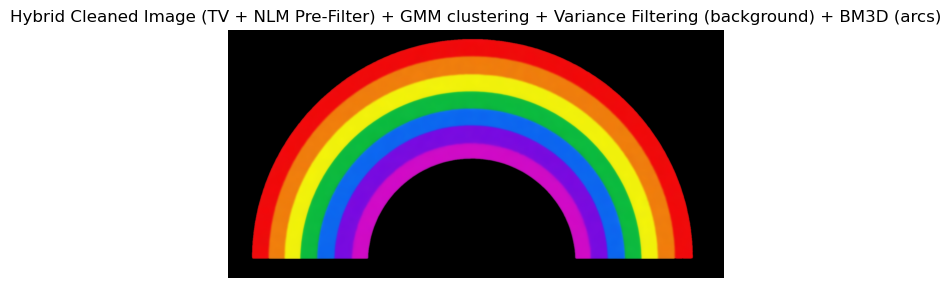

✅ Saved: final_cleaned_image_hybrid_tv_nlm.png


In [19]:
"""
Task 2
BEST BEST BEST AND FINAL -> EXPERIMENTAL VERSION
Test 13
Applies TV and NLM pre-filters before bilateral, GMM, variance, and BM3D.

task2_clean_image_gmm_bm3d_hybrid_prefilter_experiment

Author: Gregory E. Schwartz
Last Revised: 2025-05-10
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from collections import Counter
from PIL import Image, ImageEnhance
from bm3d import bm3d, BM3DStages
from skimage.restoration import denoise_tv_chambolle

# Load image
image_bgr = cv2.imread('rainbow.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_height, image_width, _ = image_rgb.shape
print(f'Loaded image with shape: {image_rgb.shape}')

# --- Apply TV Denoising as Pre-Filter ---
print("🔧 Applying Total Variation Denoising (pre-filter)")
image_rgb = denoise_tv_chambolle(image_rgb / 255.0, weight=0.1, channel_axis=-1)
image_rgb = (image_rgb * 255).astype('uint8')

# --- Apply NLM Denoising as Pre-Filter ---
print("🔧 Applying Non-Local Means Denoising (pre-filter)")
image_rgb = cv2.fastNlMeansDenoisingColored(image_rgb, None, 10, 10, 7, 21)

# Bilateral filter
bilateral_filtered = cv2.bilateralFilter(image_rgb, d=9, sigmaColor=75, sigmaSpace=75)
pixel_data = bilateral_filtered.reshape((-1, 3))

# GMM clustering
cluster_count = 7
gmm_model = GaussianMixture(n_components=cluster_count, covariance_type='tied', random_state=42)
gmm_model.fit(pixel_data)
cluster_labels = gmm_model.predict(pixel_data)
cluster_centers = gmm_model.means_.astype('uint8')

# Cluster stats
label_counts = Counter(cluster_labels)
print('\nPixels per cluster:')
for label, count in label_counts.items():
    print(f'Cluster {label}: {count} pixels')

brightness = np.mean(image_rgb, axis=2).flatten()
cluster_brightness = {
    label: np.mean(brightness[cluster_labels == label])
    for label in range(cluster_count)
}
print('\nAverage brightness per cluster:')
for label, avg_b in cluster_brightness.items():
    print(f'Cluster {label}: {avg_b:.2f}')

brightness_min = 40
brightness_max = 220
clean_cluster_ids = [label for label, mean_b in cluster_brightness.items()
                     if brightness_min < mean_b < brightness_max]

print(f'\nKeeping clusters (based on brightness): {clean_cluster_ids}')

# Filter by clean clusters
clean_mask = np.isin(cluster_labels, clean_cluster_ids)
cleaned_pixels = np.where(clean_mask[:, np.newaxis], pixel_data, [0, 0, 0])
cleaned_image = cleaned_pixels.reshape((image_height, image_width, 3))

# Variance filtering
gray_image = cv2.cvtColor(cleaned_image.astype('uint8'), cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
squared = cv2.GaussianBlur(gray_image**2, (5, 5), 0)
local_variance = squared - blurred**2
variance_threshold = 255
speckle_mask = local_variance > variance_threshold

final_cleaned = cleaned_image.copy()
final_cleaned[speckle_mask] = [0, 0, 0]

# Diagnostic stats
print(f'Local variance range: min={local_variance.min()}, max={local_variance.max()}')
print(f'Mean variance: {local_variance.mean():.2f}, StdDev: {local_variance.std():.2f}')

# BM3D denoising
normalized = final_cleaned.astype(np.float32) / 255.0
sigma_psd = 30 / 255
bm3d_denoised = bm3d(normalized, sigma_psd, stage_arg=BM3DStages.ALL_STAGES)
bm3d_denoised = (bm3d_denoised * 255).astype(np.uint8)

# Hybrid output: BM3D for arcs, variance-filtered background
rainbow_mask = np.any(final_cleaned > 10, axis=2)
hybrid_image = final_cleaned.copy()
hybrid_image[rainbow_mask] = bm3d_denoised[rainbow_mask]

# Display and save
plt.imshow(hybrid_image)
plt.title("Hybrid Cleaned Image (TV + NLM Pre-Filter) + GMM clustering + Variance Filtering (background) + BM3D (arcs)")
plt.axis('off')
plt.show()

Image.fromarray(hybrid_image.astype('uint8')).save('33final_cleaned_image_hybrid_tv_nlm.png')
print("✅ Saved: final_cleaned_image_hybrid_tv_nlm.png")


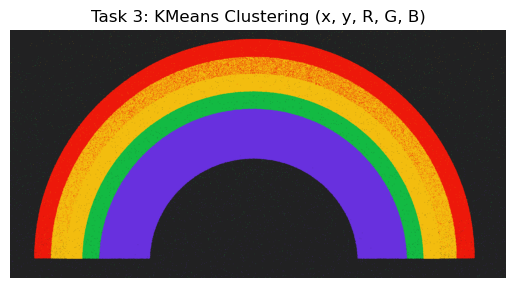

Task 3 Output Variance Stats:
Range: min=0, max=255
Mean: 26.63, StdDev: 63.41


In [11]:
"""
Task 3:Cluster using KMeans on full pixel features: (x, y, R, G, B)

Author: Gregory E. Schwartz 
Last Revised: 2025-05-10
"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 0: Load image
image_bgr = cv2.imread('rainbow.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = image_rgb.shape

# Step 1: Create full feature set (x, y, R, G, B)
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
rgb_flat = image_rgb.reshape(-1, 3)
features = np.column_stack((x_flat, y_flat, rgb_flat))

# Step 2: Standardize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Apply KMeans
kmeans = KMeans(n_clusters=7, random_state=42, n_init='auto')
labels = kmeans.fit_predict(features_scaled)

# Step 4: Map clusters to average RGB
cluster_colors = np.zeros((kmeans.n_clusters, 3), dtype='uint8')
for i in range(kmeans.n_clusters):
    cluster_colors[i] = rgb_flat[labels == i].mean(axis=0)

recolored_pixels = cluster_colors[labels]
recolored_image = recolored_pixels.reshape((h, w, 3))

# Step 5: Show image
plt.imshow(recolored_image)
plt.title("Task 3: KMeans Clustering (x, y, R, G, B)")
plt.axis('off')
plt.show()

# Step 6: Variance analysis
gray = cv2.cvtColor(recolored_image.astype('uint8'), cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
squared = cv2.GaussianBlur(gray ** 2, (5, 5), 0)
local_variance = squared - blurred ** 2

print("Task 3 Output Variance Stats:")
print(f"Range: min={local_variance.min()}, max={local_variance.max()}")
print(f"Mean: {local_variance.mean():.2f}, StdDev: {local_variance.std():.2f}")

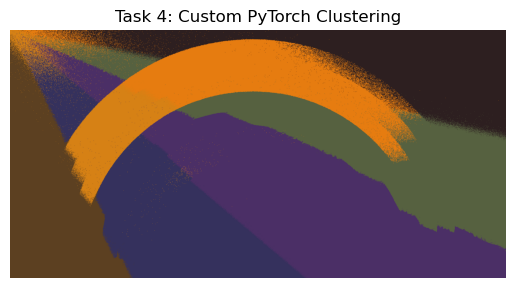

Task 4 Output Variance Stats:
Range: min=0, max=255
Mean: 17.57, StdDev: 51.42


In [21]:
"""
Task 4: Custom Clustering in PyTorch (Fixed & Final)

Author: Gregory E. Schwartz 
Last Revised: 2025-05-10
"""

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image_bgr = cv2.imread('rainbow.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = image_rgb.shape

# Prepare full feature set
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
rgb_flat = image_rgb.reshape(-1, 3)
features_np = np.column_stack((x_flat, y_flat, rgb_flat)).astype(np.float32)

# Convert to tensor and normalize
features = torch.from_numpy(features_np)
features = F.normalize(features, dim=1)

# Initialize centroids
k = 7
indices = torch.randperm(features.shape[0])[:k]
centroids = features[indices]

# Clustering loop
for i in range(10):
    distances = torch.cdist(features, centroids)
    labels = torch.argmin(distances, dim=1)

    new_centroids = []
    for j in range(k):
        cluster_points = features[labels == j]
        if cluster_points.shape[0] > 0:
            new_centroids.append(cluster_points.mean(dim=0))
        else:
            new_centroids.append(centroids[j])  # fallback
    centroids = torch.stack(new_centroids)

# Recolor based on average RGB of each cluster
label_np = labels.numpy()
cluster_colors = np.zeros((k, 3), dtype='uint8')
for i in range(k):
    cluster_colors[i] = rgb_flat[label_np == i].mean(axis=0)

recolored_pixels = cluster_colors[label_np]
recolored_image = recolored_pixels.reshape((h, w, 3))

# Show final image
plt.imshow(recolored_image)
plt.title("Task 4: Custom PyTorch Clustering")
plt.axis('off')
plt.show()

# Variance statistics
gray = cv2.cvtColor(recolored_image.astype('uint8'), cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
squared = cv2.GaussianBlur(gray ** 2, (5, 5), 0)
local_variance = squared - blurred ** 2

print("Task 4 Output Variance Stats:")
print(f"Range: min={local_variance.min()}, max={local_variance.max()}")
print(f"Mean: {local_variance.mean():.2f}, StdDev: {local_variance.std():.2f}")
